In [6]:
# --- SETUP ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')


# Cargar archivo .env
# Ruta relativa desde el notebook hasta el .env
dotenv_path = '../generadores/.env'  #

# Cargar el archivo .env desde la ruta especificada
load_dotenv(dotenv_path=dotenv_path)

# Leer variables de entorno
username = os.getenv("USUARIO_DB")
password = os.getenv("CLAVE_BD")

# Validar que se cargaron bien
print("Usuario:", username)
print("Contraseña cargada:", bool(password))  # No imprime la clave, pero verifica si existe

if not username or not password:
    raise ValueError("Las variables de entorno USUARIO_DB o CLAVE_BD no están definidas")

# Cadena de conexión
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=upgradeserver-vf.database.windows.net;'
    'DATABASE=Banco;'
    f'UID={username};'
    f'PWD={password};'
    'Connection Timeout=30;'
)

# Conexión
conn = pyodbc.connect(conn_str)



Usuario: vanesa
Contraseña cargada: True


In [7]:
usuarios = pd.read_sql_query("SELECT * FROM usuarios", conn)
creditos = pd.read_sql_query("SELECT * FROM creditos", conn)
activos_financieros = pd.read_sql_query("SELECT usuario_id, tipo_activo, monto FROM activos_financieros", conn)
monedas_digitales = pd.read_sql_query("SELECT * FROM monedas_digitales", conn)
cuentas_bancarias = pd.read_sql_query("SELECT * FROM cuentas_bancarias", conn)

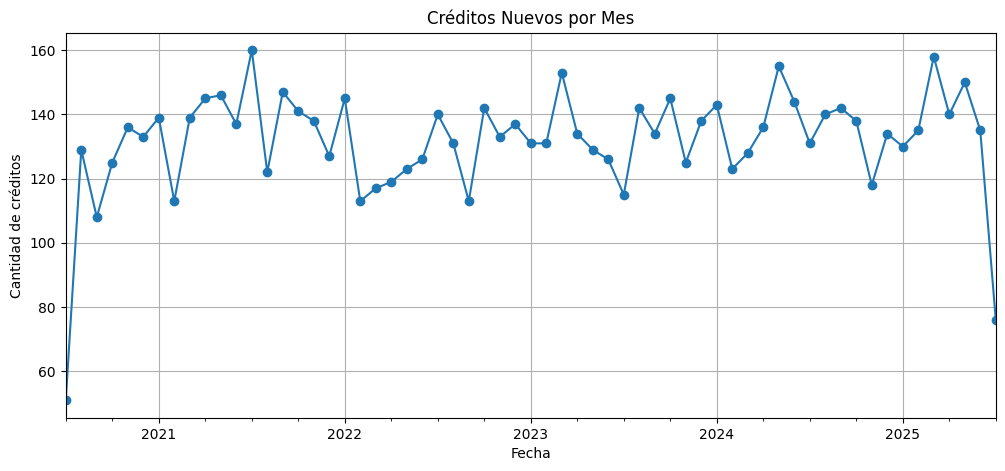


📈 Predicción de nuevos créditos para los próximos 6 meses:
       fecha  pred_creditos
0 2025-07-31          137.0
1 2025-08-31          137.0
2 2025-09-30          137.0
3 2025-10-31          137.0
4 2025-11-30          138.0
5 2025-12-31          138.0


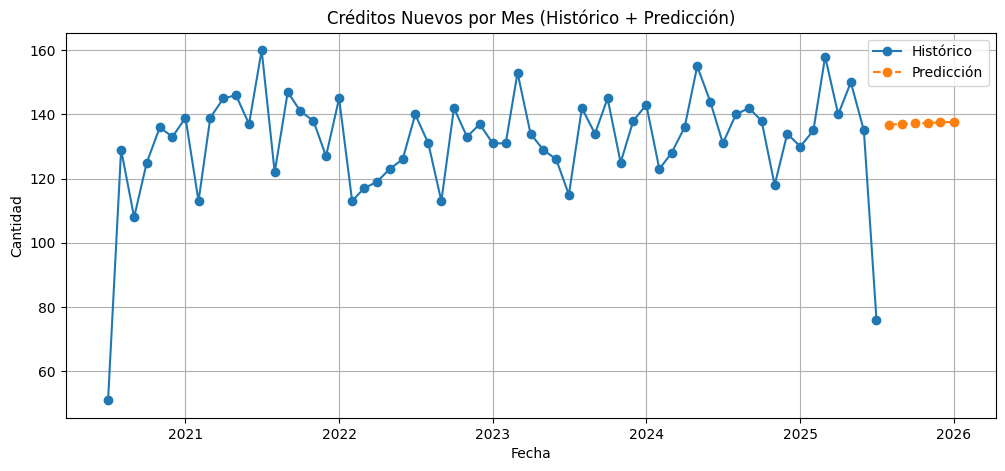

In [11]:
# --- PREDICCIÓN A 6 MESES: NUEVOS CRÉDITOS ---
from sklearn.linear_model import LinearRegression
# Crear copia temporal para no modificar el DataFrame original
creditos_copia = creditos.copy()
creditos_copia['fecha_inicio'] = pd.to_datetime(creditos_copia['fecha_inicio'], errors='coerce')

# Agrupar por mes
creditos_por_mes = (
    creditos_copia
    .groupby(creditos_copia['fecha_inicio'].dt.to_period('M'))
    .size()
    .to_timestamp()
)

# Visualización histórica
creditos_por_mes.plot(marker='o', figsize=(12, 5), title='Créditos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de créditos")
plt.xlabel("Fecha")
plt.show()

# Crear variables para regresión
df_creditos = creditos_por_mes.reset_index()
df_creditos.columns = ['fecha', 'nuevos_creditos']
df_creditos['mes_num'] = np.arange(len(df_creditos))

# Entrenar modelo lineal
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_creditos[['mes_num']], df_creditos['nuevos_creditos'])

# Predecir los próximos 6 meses
futuro_creditos = pd.DataFrame({'mes_num': np.arange(len(df_creditos), len(df_creditos) + 6)})
futuro_creditos['pred_creditos'] = modelo_creditos.predict(futuro_creditos[['mes_num']])
futuro_creditos['fecha'] = pd.date_range(df_creditos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicción
print("\n📈 Predicción de nuevos créditos para los próximos 6 meses:")
print(futuro_creditos[['fecha', 'pred_creditos']].round(0))

# Visualización combinada
plt.figure(figsize=(12, 5))
plt.plot(df_creditos['fecha'], df_creditos['nuevos_creditos'], label='Histórico', marker='o')
plt.plot(futuro_creditos['fecha'], futuro_creditos['pred_creditos'], label='Predicción', marker='o', linestyle='--')
plt.title("Créditos Nuevos por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()

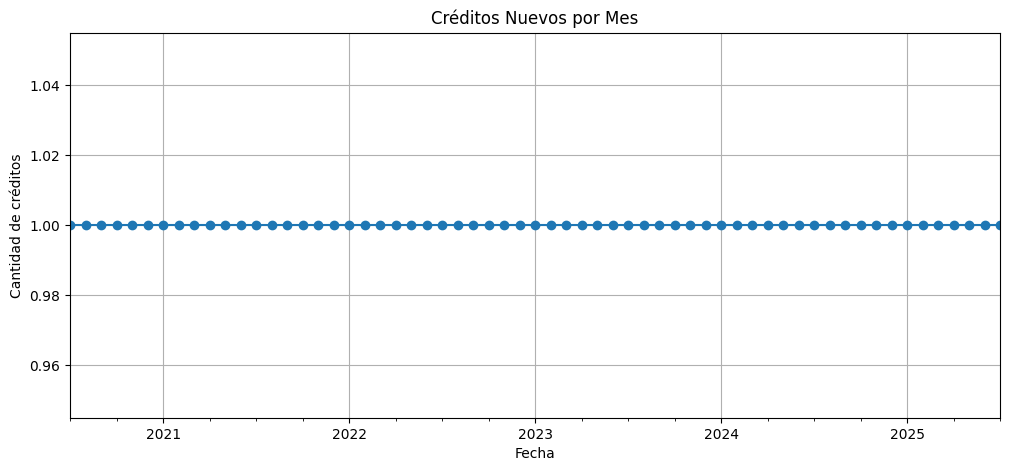


Predicción de nuevos créditos para los próximos 6 meses:
       fecha  pred_creditos
0 2025-07-31            1.0
1 2025-08-31            1.0
2 2025-09-30            1.0
3 2025-10-31            1.0
4 2025-11-30            1.0
5 2025-12-31            1.0


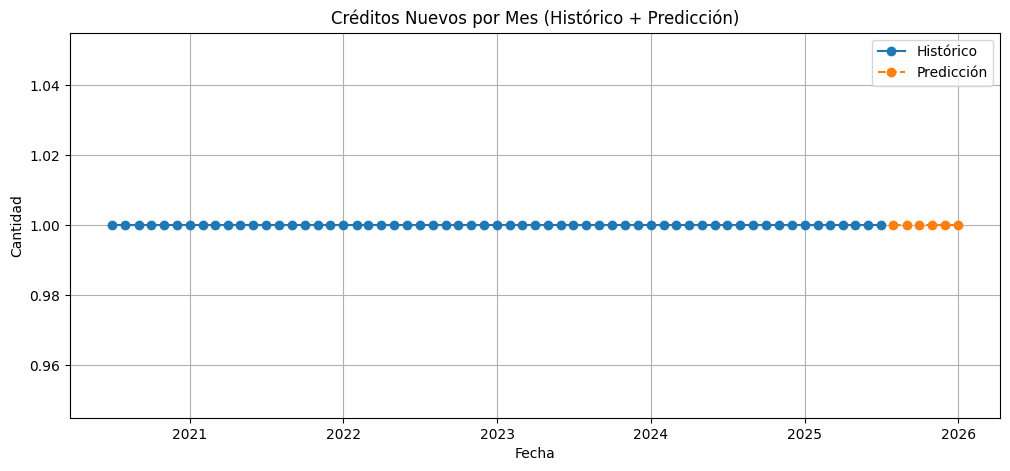

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import MonthEnd

# Asegura que las fechas estén como datetime sin modificar el original
df_creditos_fecha = df_creditos.copy()
df_creditos_fecha['fecha'] = pd.to_datetime(df_creditos_fecha['fecha'], errors='coerce')

# Agrupar por mes
creditos_por_mes = df_creditos_fecha.groupby(df_creditos_fecha['fecha'].dt.to_period('M')).size().to_timestamp()

# Visualización
creditos_por_mes.plot(marker='o', figsize=(12, 5), title='Créditos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de créditos")
plt.xlabel("Fecha")
plt.show()

# Crear variables de regresión
df_pred_creditos = creditos_por_mes.reset_index()
df_pred_creditos.columns = ['fecha', 'nuevos_creditos']
df_pred_creditos['mes_num'] = np.arange(len(df_pred_creditos))

# Modelo
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_pred_creditos[['mes_num']], df_pred_creditos['nuevos_creditos'])

# Predicción 6 meses
futuro_creditos = pd.DataFrame({'mes_num': np.arange(len(df_pred_creditos), len(df_pred_creditos) + 6)})
futuro_creditos['pred_creditos'] = modelo_creditos.predict(futuro_creditos[['mes_num']])
futuro_creditos['fecha'] = pd.date_range(df_pred_creditos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicción
print("\nPredicción de nuevos créditos para los próximos 6 meses:")
print(futuro_creditos[['fecha', 'pred_creditos']].round(0))

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(df_pred_creditos['fecha'], df_pred_creditos['nuevos_creditos'], label='Histórico', marker='o')
plt.plot(futuro_creditos['fecha'], futuro_creditos['pred_creditos'], label='Predicción', marker='o', linestyle='--')
plt.title("Créditos Nuevos por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#!pip install sqlalchemy pyodbc

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import MonthEnd

# Crear copia para no modificar el df original
df_temp = df_creditos.copy()

# Asegurar que 'fecha_inicio' sea datetime (ignorar errores para no romper)
df_temp['fecha'] = pd.to_datetime(df_temp['fecha'], errors='coerce')

# Agrupar por mes y sumar montos
monto_mensual = df_temp.groupby(df_temp['fecha'].dt.to_period('M'))['monto'].sum().to_timestamp()

# Visualización
monto_mensual.plot(marker='o', figsize=(12, 5), title='Monto Total Otorgado en Créditos por Mes')
plt.grid(True)
plt.ylabel("Monto total")
plt.xlabel("Fecha")
plt.show()

# Preparar dataframe para regresión
df_monto = monto_mensual.reset_index()
df_monto.columns = ['fecha', 'monto']
df_monto['mes_num'] = np.arange(len(df_monto))

# Entrenar modelo lineal
modelo_monto = LinearRegression()
modelo_monto.fit(df_monto[['mes_num']], df_monto['monto_total_creditos'])

# Predecir para el próximo mes
futuro_monto = pd.DataFrame({'mes_num': [len(df_monto)]})
futuro_monto['pred_monto'] = modelo_monto.predict(futuro_monto[['mes_num']])
futuro_monto['fecha'] = [df_monto['fecha'].max() + MonthEnd(1)]

print("\nPredicción del monto total de créditos para el próximo mes:")
print(futuro_monto[['fecha', 'pred_monto']].round(0))

# Visualización histórico + predicción
plt.figure(figsize=(12, 5))
plt.plot(df_monto['fecha'], df_monto['monto_total_creditos'], label='Histórico', marker='o')
plt.plot(futuro_monto['fecha'], futuro_monto['pred_monto'], label='Predicción', marker='o', linestyle='--')
plt.title("Monto Total Otorgado en Créditos (Histórico + Predicción para 1 Mes)")
plt.ylabel("Monto")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'Column not found: monto'

In [ ]:
import pandas as pd
import sqlalchemy
import urllib

# Tus variables de entorno ya cargadas (username, password)

# Construir la cadena de conexión para SQLAlchemy con pyodbc
params = urllib.parse.quote_plus(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER=upgradeserver-vf.database.windows.net;"
    f"DATABASE=Banco;"
    f"UID={username};"
    f"PWD={password};"
    "Connection Timeout=30;"
)

engine = sqlalchemy.create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

query = """
SELECT id, usuario_id, monto_total_creditos, fecha_inicio, fecha_fin, estado, tipo,
       duracion_dias, duracion_credito, provincia, provincia_nombre
FROM creditos
"""

df_creditos = pd.read_sql(query, engine)

print(df_creditos.columns)
print(df_creditos.head())


In [ ]:
# --- PREDICCION DE MOROSOS NUEVOS POR MES ---
primer_credito_morosidad = creditos.sort_values('fecha_inicio').drop_duplicates('id')
primer_credito_morosidad = primer_credito_morosidad.merge(usuarios[['id', 'es_moroso']], on='id')

morosos_por_mes = primer_credito_morosidad[primer_credito_morosidad['es_moroso'] == 1].groupby(
    primer_credito_morosidad['fecha_inicio'].dt.to_period('M')
).size().to_timestamp()

# Visualización
morosos_por_mes.plot(marker='o', figsize=(12, 5), title='Morosos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.show()

# Predicción
df_morosos = morosos_por_mes.reset_index()
df_morosos.columns = ['fecha', 'morosos']
df_morosos['mes_num'] = np.arange(len(df_morosos))

modelo_morosos = LinearRegression()
modelo_morosos.fit(df_morosos[['mes_num']], df_morosos['morosos'])

futuro_morosos = pd.DataFrame({'mes_num': np.arange(len(df_morosos), len(df_morosos) + 6)})
futuro_morosos['pred'] = modelo_morosos.predict(futuro_morosos[['mes_num']])
futuro_morosos['fecha'] = pd.date_range(df_morosos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

print("\nPredicción de morosos nuevos para los próximos 6 meses:")
print(futuro_morosos[['fecha', 'pred']].round(0))

plt.figure(figsize=(12, 5))
plt.plot(df_morosos['fecha'], df_morosos['morosos'], label='Histórico', marker='o')
plt.plot(futuro_morosos['fecha'], futuro_morosos['pred'], label='Predicción', marker='o', linestyle='--')
plt.title("Morosos Nuevos por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()
